In [1]:
import sim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
##Part 1
import sim as vrep
import time
import cv2
import numpy as np
from matplotlib.transforms import Affine2D

vrep.simxFinish(-1)

clientID = vrep.simxStart('192.168.50.196', 19999, True, True, 5000, 5)

if clientID!=-1:
    # Handler for the camera
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    print ('Getting first image')
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    
    # Take p pictures
    p = 10
    i = 0
    orientations = []
    images = []
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        if err == vrep.simx_return_ok:
            print ("image %d OK!!!"%i)
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            # Show the images using Opencv (uncomment if you want to try it)
#             cv2.imshow('image',img)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
            i+=1
            orientation = vrep.simxGetObjectOrientation(clientID, v1, -1, vrep.simx_opmode_blocking)[1][1]
            orientations.append(orientation)
            images.append(img)
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(1)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

print(orientations)

Getting first image
no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!
[0.6330958604812622, 0.3475267291069031, 0.054971981793642044, -0.24201537668704987, -0.5388727188110352, -0.8381590247154236, -1.1381480693817139, -1.4449774026870728, -1.3887157440185547, -1.0851502418518066]


In [3]:
circles_arr = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray,5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)
    if circles is not None:
        max_rad = 0
        largest = circles[0][0]
        for circle in circles[0, :]:
            if circle[2] > max_rad:
                largest = circle
        circles_arr.append(largest)
    #imshow(gray, cmap='gray')



#print(circles)
i = 0
#plot(0,0,'*')
centers = []
radii = []
angles = []
for circle in circles_arr:
    angle = orientations[i]
    center = (circle[0], circle[1])  # In pixels
    #center = rotate([0,0],center,degrees(angle))
    radius = circle[2]  # In pixels
    centers.append(center)
    radii.append(radius)
    angles.append(angle)
    # plot circle
    s = linspace(0,2*pi,100)
    cx = cos(s)*radius + center [0]
    cy = sin(s)*radius + center [1]

    # Plot center
    #plot(center[0], center[1], '*')
    #plot(cx,cy)

            
    i+=1
            


[2.78072029 7.26580624]
[[ 0.80619973 -0.59164347]
 [ 0.59164347  0.80619973]]
[0.68333333 7.62102355]
[[ 0.94021792 -0.34057344]
 [ 0.34057344  0.94021792]]
[-1.51066348  8.12668374]
[[ 0.99848942 -0.0549443 ]
 [ 0.0549443   0.99848942]]
[-3.5090362   6.88646717]
[[ 0.97085694  0.23965975]
 [-0.23965975  0.97085694]]
[0.64463957 3.16955702]
[[ 0.85828771  0.51316879]
 [-0.51316879  0.85828771]]
[-0.1152664   3.51379165]
[[ 0.66883256  0.74341308]
 [-0.74341308  0.66883256]]
[-2.34374992  7.39107863]
[[ 0.41927651  0.90785858]
 [-0.90785858  0.41927651]]
[1.46205364 5.10336422]
[[ 0.12548723  0.99209524]
 [-0.99209524  0.12548723]]
[-0.11175496  5.67791476]
[[ 0.18107615  0.98346908]
 [-0.98346908  0.18107615]]
[2.38846154 5.27609323]
[[ 0.46677984  0.88437355]
 [-0.88437355  0.46677984]]


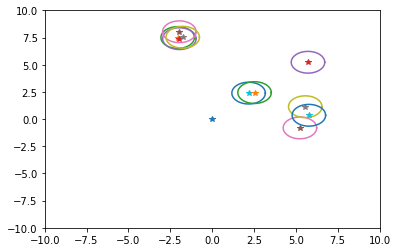

In [12]:
u0, v0 = 132, 132

xzcs = []
i = 0
plot(0,0,"*")
for center in centers:
    radius = radii[i]
    k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
    fov = 60  # degrees
    angle = angles[i]
    
    rot = np.array(((cos(angle), -sin(angle)),(sin(angle), cos(angle))))
    
    
    # number of pixels in x-axis
    npx = 264

    # maximum value in the x-axis (in meters)
    xmax = npx / (2.* k)

    # Distance to the center of the sphere (z-axis coordinate)
    zc = xmax / tan(pi/6)

    # Location of the sphere in the x-axis coordinate
    xc = (center[0] - u0) / k
    
    cur = np.array((xc,zc))
    print(cur)
    print(rot)
    #[xc,zc] = rot*cur
    new = rot.dot(cur)

    xc = new[0]
    zc = new[1]
    xzcs.append([xc,zc])
    plot(xc,zc,'*')
    s = linspace(0,2*pi,100)
    cx = cos(s) + xc
    cy = sin(s) + zc
    plot(cx,cy)
    plt.axis((-10,10,-10,10))
    
    i+=1

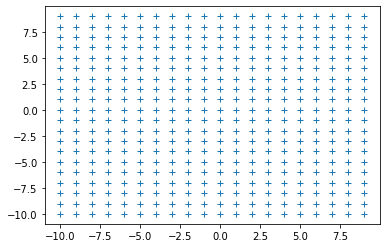

In [5]:
# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

plot(grid_x, grid_y, '+')

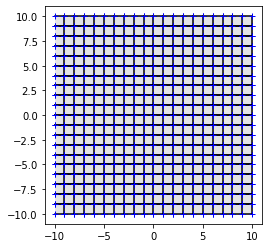

In [6]:
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

In [7]:
l0 = (0.3/(1-0.3))  # Initial belief
gmap = l0 * ones(n*n) # Initial belief
print(len(xzcs))
print(len(angles))
# For each cell, check if the circle is in it.
for i in range(n*n):
    x, y = grid_x[i], grid_y[i]
    #TODO Run this for each sphere (center and radius)
    # Corners of the cell
    X, Y = points_cell(x, y, cell_w)
    # check based on the ecuclidean distance
    for j in range(0,len(xzcs)):
        xc,zc = xzcs[j]
        dist = sqrt((xc - X)**2 + (zc - Y)**2)
        radius = radii[j]
        angle = angles[j]
        # Check if At least one of the borders is within the sphere
        if((dist < radius/k).any()):
            print(dist)
            po = 0.8  # P(mi/zt) probability of having an obstacle 
            li = log(po / (1-po)) + gmap[i] - l0
            gmap[i] = li  # P(mi/zt) 
            print(li)
        else:
            po = 0.05  # P(mi/zt) probability of having an obstacle given a non-detected obstacle

            # Cells within the fov. Check if the four points are withing the FOV
            #thetas = np.arctan2(Y,X) - pi/2 - angle
            thetas = 2*pi
            if np.logical_and(-pi/6 <thetas, thetas < pi/6).all():
                li = log(po / (1-po)) + gmap[i] - l0
                gmap[i] = li

            pass

# gmap

10
10
[1.77426268 1.5039647  0.50610054 1.06875442]
1.3862943611198908
[1.74669739 1.39893662 0.40090836 1.12011411]
2.3440172936683528
[1.06875442 0.50610054 0.50036557 1.06605064]
1.3862943611198908
[1.12011411 0.40090836 0.6036815  1.20762555]
2.3440172936683528
[1.46834551 1.03239112 0.05496025 1.04557531]
3.3017402262168147
[1.35059151 0.58036511 0.53228304 1.33063856]
4.259463158765277
[1.06605064 0.50036557 1.4981968  1.76937613]
1.3862943611198908
[1.04557531 0.05496025 0.96964418 1.424927  ]
2.3440172936683528
[1.33063856 0.53228304 1.49326046 1.92797836]
3.3017402262168147
[1.5039647  1.83733817 1.17048687 0.50610054]
1.3862943611198908
[1.39893662 1.69206843 1.03285982 0.40090836]
2.3440172936683528
[0.50610054 1.17048687 1.1680186  0.50036557]
1.3862943611198908
[0.40090836 1.03285982 1.12716603 0.6036815 ]
2.3440172936683528
[1.03239112 1.40556903 0.95541275 0.05496025]
3.3017402262168147
[0.58036511 0.92171032 0.89221717 0.53228304]
4.259463158765277
[0.50036557 1.1680186

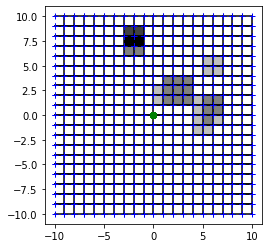

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
fig.canvas.draw()